<a href="https://colab.research.google.com/github/SrijaG29/Telecom_customer_churn/blob/main/Teleco_communication_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'telco-customer-churn:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F13996%2F18858%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240828%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240828T051007Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc3801589e6b30654e84548ae2a8056d510a278634f32688dcd486a43db5e8e17e3c4698091583e01a71bcd98f079281fbbdcb5fe33a358a011ab655045180e9e978751914e87c89fe919fafe7596476fcd86da103f2d1b357012a5ba594d266144067a3f028a5ba25767070c1de519ae0f2ae05922e242fb8e3ad9ec7023e3b5002da1e8666d1599a1f95c7c8a2b6ef0f3e6208b2278489dd75d4cfeb9e82d1c5e8809a7d35c2f0800f8457cdd9ba521a7fdebd567ce692b0417eacb34323ae728a7ced84ace6b638dcfa7dfd48944ecdd50f335ca298250b609025fc9caefd1cab00efd387a495e987465f0ebd207005c5ab3e0e09b821cf15e7534386f4b6b'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 175758 bytes downloaded
Downloaded and uncompressed: telco-customer-churn
Data source import complete.


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.3/317.3 MB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.2-py2.py3-none-any.whl size=317812365 sha256=0c37f0a0e0aa31765f76bf4adcd987b5a93793ecf9b4b89cdbd51ab9b516cadb
  Stored in directory: /root/.cache/pip/wheels/34/34/bd/03944534c44b677cd5859f248090daa9fb27b3c8f8e5f49574
Successfully built pyspark


In [4]:
from pyspark.sql import SparkSession

In [5]:
spark = (
    SparkSession
    .builder
    .appName('Telec customer chunk')
    .master("local[*]")
    .getOrCreate()
)

In [6]:
spark

In [26]:
telecom_df = spark.read.format('csv').option('header',True).load('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')

In [27]:
telecom_df.show(truncate = False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|0            |Yes    |No   

In [28]:
telecom_df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



Now we will change the Datatypes of columns according to their values.

In [29]:
from pyspark.sql.functions import col,round

In [270]:
telecom_df_copy = telecom_df.withColumn('SeniorCitizen',col('SeniorCitizen').cast("int"))\
                            .withColumn('tenure',col('tenure').cast("int"))\
                            .withColumn('MonthlyCharges',round(col('MonthlyCharges'),0).cast("int"))\
                            .withColumn('TotalCharges',round(col('TotalCharges'),0).cast("int"))

In [271]:
telecom_df_copy.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: integer (nullable = true)
 |-- TotalCharges: integer (nullable = true)
 |-- Churn: string (nullable = true)



Check no of null values in each column.

In [69]:
check_null = telecom_df_copy.toPandas()
check_null.isna().sum()

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


Removing null values form TotalCharges column.

In [70]:
x = telecom_df_copy.filter(telecom_df_copy.TotalCharges.isNull())

In [71]:
x.show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|4472-LVYGI|Female|            0|    Yes|       Yes|     0|          No|No phon

We can calculate totalchargers by multiplying monthlychargers and tenure.

In [72]:
telecom_df_copy.filter(telecom_df_copy.MonthlyCharges == 0).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-

In [73]:
telecom_df_copy.filter(telecom_df_copy.tenure == 0).show()

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------+----------------+--------------------+--------------+------------+-----+
|4472-LVYGI|Female|            0|    Yes|       Yes|     0|          No|No phon

In [74]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType

In [75]:
def calculating_totalcharges(TotalCharges,MonthlyCharges,tenure):
  if TotalCharges is None:
    if tenure == 0:
      return MonthlyCharges
    else:
      return tenure*MonthlyCharges
  else:
    return TotalCharges

x_udf = udf(calculating_totalcharges,IntegerType())

telecom_df_copy = telecom_df_copy.withColumn("TotalCharges",x_udf(telecom_df_copy.TotalCharges,telecom_df_copy.MonthlyCharges,telecom_df_copy.tenure))


In [76]:
telecom_df_copy.filter(telecom_df_copy.TotalCharges.isNull()).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-

In [126]:
telecom_pandas_df = telecom_df_copy.toPandas()

Bar plot on Gender and Churn columns to check whether gender column effect churning of customers or not.

In [127]:
import seaborn as sns
import pandas as pd


In [128]:
telecom_pandas_df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,30,30,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,57,1890,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,54,108,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42,1841,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,71,152,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,85,1991,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103,7363,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,30,346,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74,307,Yes


In [144]:
print(telecom_pandas_df.columns)

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')


In [129]:
print(telecom_pandas_df['Churn'].unique())

['No' 'Yes']


In [130]:
telecom_pandas_df['Churn'] = telecom_pandas_df['Churn'].map({'Yes':1,'No':0})

In [131]:
print(telecom_pandas_df['Churn'].unique())

[0 1]


In [132]:
telecom_gender_df = telecom_pandas_df.groupby('gender').Churn.sum().reset_index()

In [133]:
telecom_gender_df

,gender,Churn
0,Female,939
1,Male,930


<Axes: xlabel='gender', ylabel='Churn'>

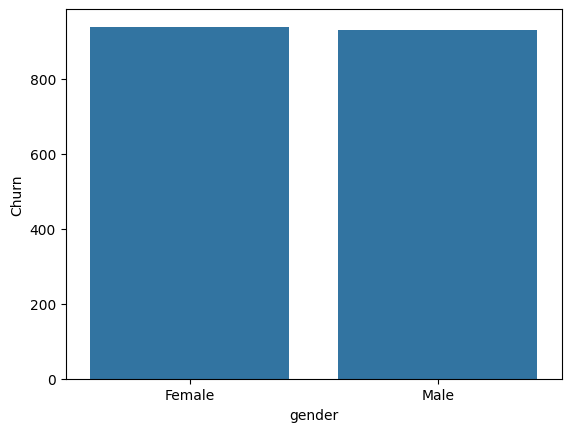

In [134]:
sns.barplot(data = telecom_gender_df,x = 'gender',y='Churn')

**Conclusion:** As there is no much difference between male and females churning so we can drop this column.

Senior citizen and Churn count.

In [135]:
telecom_senior_df = telecom_pandas_df.groupby('SeniorCitizen').Churn.sum().reset_index()

In [136]:
telecom_senior_df

,SeniorCitizen,Churn
0,0,1393
1,1,476


<Axes: xlabel='SeniorCitizen', ylabel='Churn'>

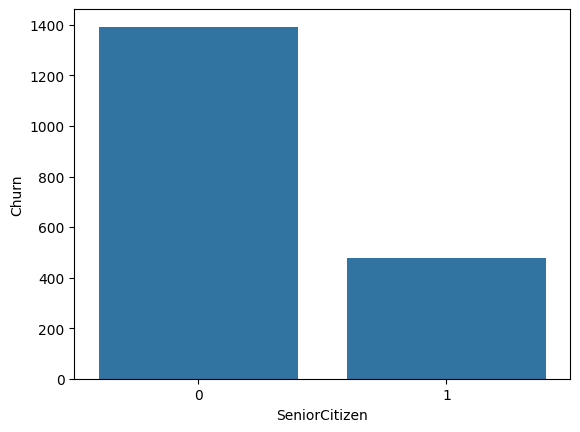

In [137]:
sns.barplot(data = telecom_senior_df,x = 'SeniorCitizen',y='Churn')

**Conclusion:** Here 0 mean Senior Citizens and 1 means Non Senior citizen so then number of customers who are churning belong to senior citizens.

Partner and Churn count.

In [138]:
telecom_partner_df = telecom_pandas_df.groupby('Partner').Churn.sum().reset_index()

In [139]:
telecom_partner_df

,Partner,Churn
0,No,1200
1,Yes,669


<Axes: xlabel='Partner', ylabel='Churn'>

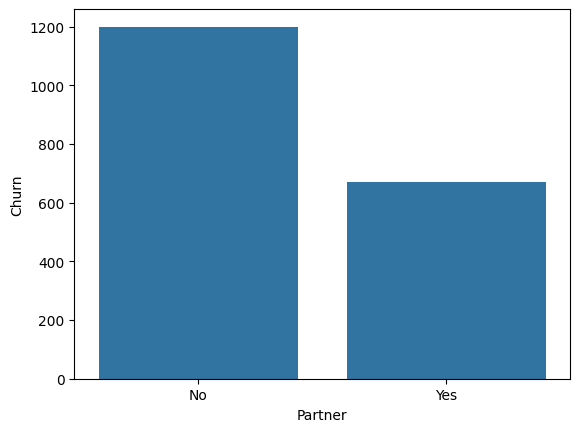

In [140]:
sns.barplot(data = telecom_partner_df,x='Partner',y = 'Churn')

Dependents and Churn count.

In [141]:
telecom_dependents_df = telecom_pandas_df.groupby('Dependents').Churn.sum().reset_index()

In [142]:
telecom_dependents_df

,Dependents,Churn
0,No,1543
1,Yes,326


<Axes: xlabel='Dependents', ylabel='Churn'>

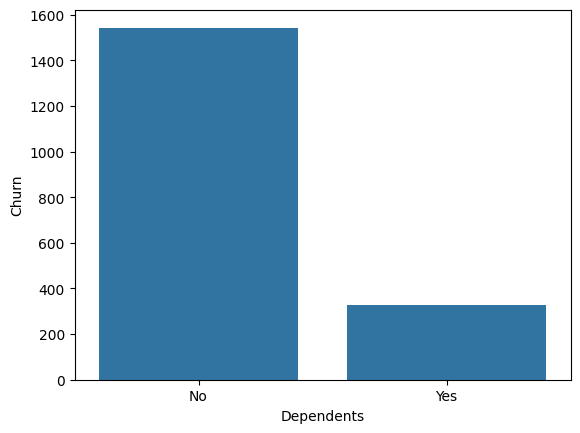

In [143]:
sns.barplot(data = telecom_dependents_df,x = 'Dependents' , y = 'Churn')

**Conclusion:** The customers who do not have Dependents are churniong more when compared to the customers who have dependents.

tenure and churn count

In [145]:
telecom_tenure_df = telecom_pandas_df.groupby('tenure').Churn.sum().reset_index()

In [146]:
telecom_tenure_df

,tenure,Churn
0,0,0
1,1,380
2,2,123
3,3,94
4,4,83
...,...,...
68,68,9
69,69,8
70,70,11
71,71,6


<Axes: xlabel='tenure', ylabel='Churn'>

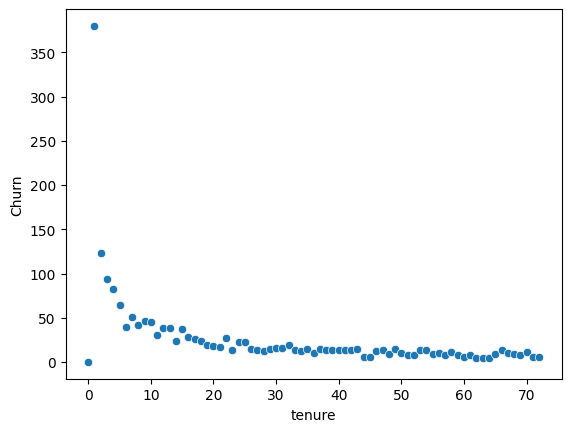

In [147]:
sns.scatterplot(data = telecom_tenure_df ,x ='tenure',y='Churn')

**Conclusion:** The customers who have less number of tenure are churning more.

PhoneService and Churn

In [148]:
telecom_phoneservice_df = telecom_pandas_df.groupby('PhoneService').Churn.sum().reset_index()

In [149]:
telecom_phoneservice_df

,PhoneService,Churn
0,No,170
1,Yes,1699


<Axes: xlabel='PhoneService', ylabel='Churn'>

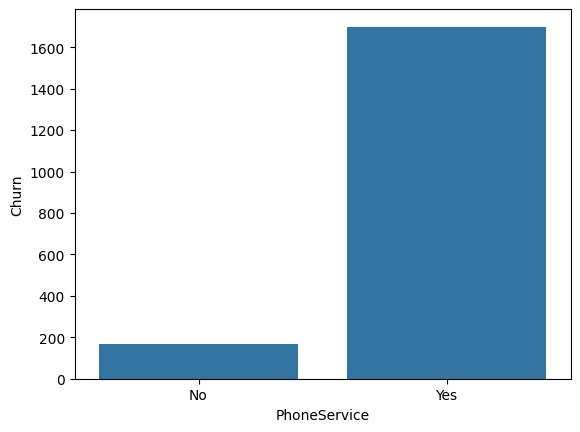

In [150]:
sns.barplot(data = telecom_phoneservice_df,x = 'PhoneService',y='Churn')

MultipleLines and Churn

In [151]:
telecom_MultipleLines_df = telecom_pandas_df.groupby('MultipleLines').Churn.sum().reset_index()

In [155]:
telecom_MultipleLines_df

,MultipleLines,Churn
0,No,849
1,No phone service,170
2,Yes,850


<Axes: xlabel='MultipleLines', ylabel='Churn'>

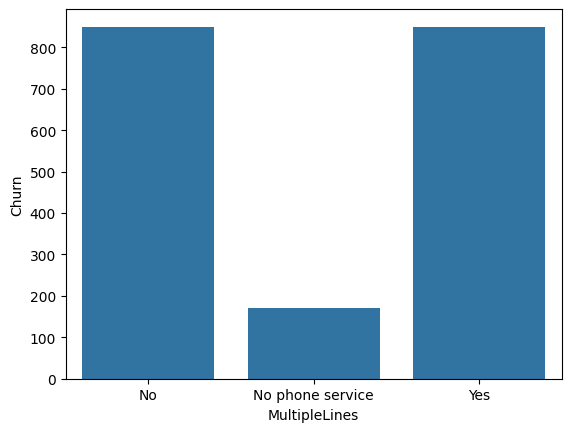

In [156]:
sns.barplot(data = telecom_MultipleLines_df,x = 'MultipleLines',y='Churn')

**Conclusion:**  849 customers without multiple lines have churned, 170 customers who do not have phone service at all have churned and 850 customers with multiple lines have churned.

InternetService and churn Count.

In [157]:
telecom_InternetService_df = telecom_pandas_df.groupby('InternetService').Churn.sum().reset_index()

In [158]:
telecom_InternetService_df

,InternetService,Churn
0,DSL,459
1,Fiber optic,1297
2,No,113


<Axes: xlabel='InternetService', ylabel='Churn'>

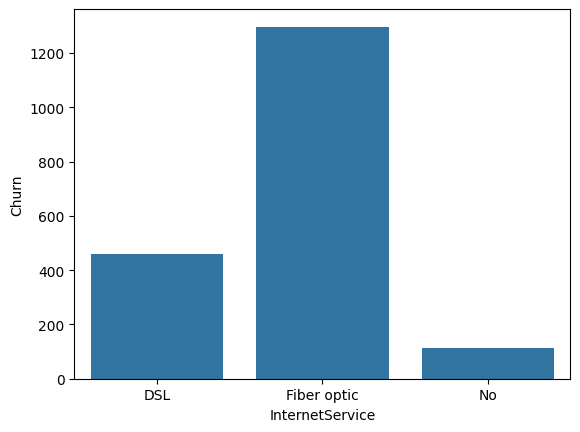

In [159]:
sns.barplot(data = telecom_InternetService_df,x = 'InternetService',y='Churn')

**Conclusion:** The customers who have Fiber optic InternetService have churned more than DSL InternetService.

OnlineSecurity and churn Count.

In [160]:
telecom_OnlineSecurity_df = telecom_pandas_df.groupby('OnlineSecurity').Churn.sum().reset_index()

In [161]:
telecom_OnlineSecurity_df

,OnlineSecurity,Churn
0,No,1461
1,No internet service,113
2,Yes,295


<Axes: xlabel='OnlineSecurity', ylabel='Churn'>

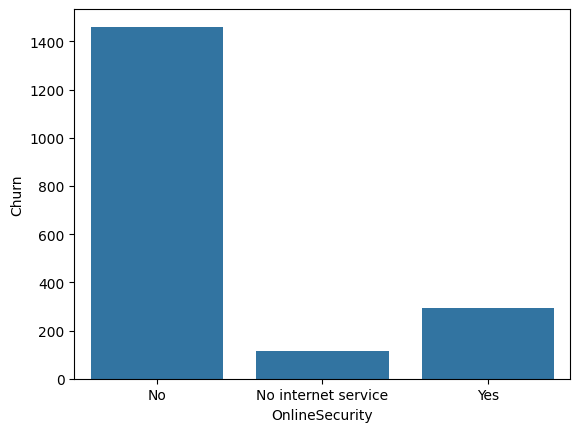

In [162]:
sns.barplot(data = telecom_OnlineSecurity_df,x = 'OnlineSecurity',y='Churn')

**Conclusion:** The people who do not have Online Security are churning more.

DeviceProtectionv and churn Count.

In [166]:
telecom_DeviceProtection_df = telecom_pandas_df.groupby('DeviceProtection').Churn.sum().reset_index()

In [167]:
telecom_DeviceProtection_df

,DeviceProtection,Churn
0,No,1211
1,No internet service,113
2,Yes,545


<Axes: xlabel='DeviceProtection', ylabel='Churn'>

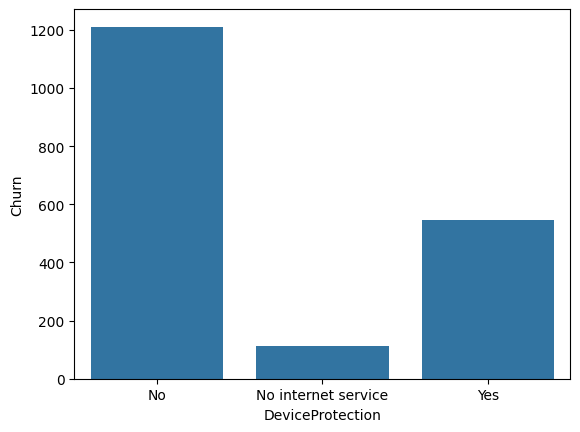

In [168]:
sns.barplot(data = telecom_DeviceProtection_df,x = 'DeviceProtection',y='Churn')

**Conclusion:** The customers who don't have DevicePretection are churing more.

TechSupport and churn Count.

In [169]:
telecom_TechSupport_df = telecom_pandas_df.groupby('TechSupport').Churn.sum().reset_index()

In [170]:
telecom_TechSupport_df

,TechSupport,Churn
0,No,1446
1,No internet service,113
2,Yes,310


<Axes: xlabel='TechSupport', ylabel='Churn'>

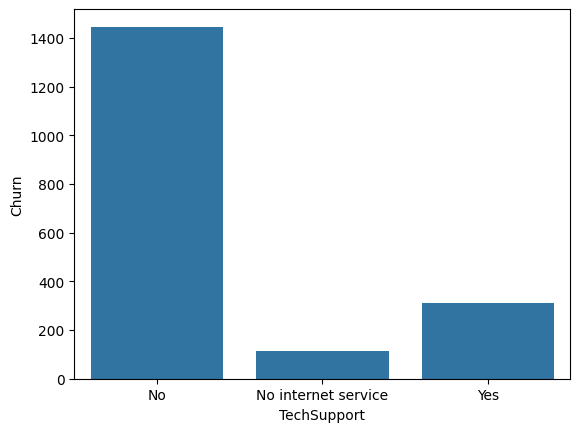

In [171]:
sns.barplot(data = telecom_TechSupport_df,x = 'TechSupport',y='Churn')

**Conclusion:** The customers who don't have TechSupport are churing more.

StreamingTV and churn Count.

In [172]:
telecom_StreamingTV_df = telecom_pandas_df.groupby('StreamingTV').Churn.sum().reset_index()

In [173]:
telecom_StreamingTV_df

,StreamingTV,Churn
0,No,942
1,No internet service,113
2,Yes,814


<Axes: xlabel='StreamingTV', ylabel='Churn'>

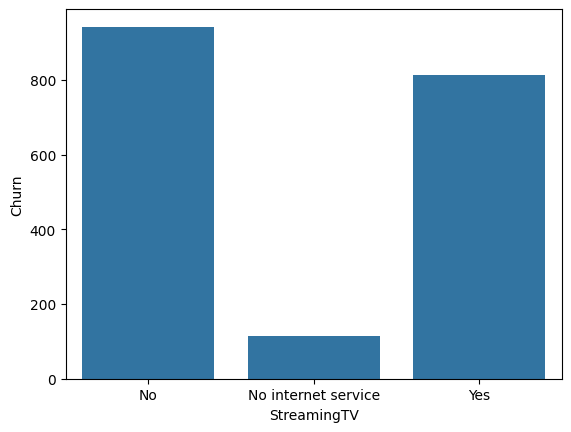

In [174]:
sns.barplot(data = telecom_StreamingTV_df,x = 'StreamingTV',y='Churn')

**Conclusion:** The customers who don't have StreamingTv are churing sighlty more when compared with the people who have StreamingTv.

StreamingMovies and churn Count.

In [175]:
telecom_StreamingMovies_df = telecom_pandas_df.groupby('StreamingMovies').Churn.sum().reset_index()

In [176]:
telecom_StreamingMovies_df

,StreamingMovies,Churn
0,No,938
1,No internet service,113
2,Yes,818


<Axes: xlabel='StreamingMovies', ylabel='Churn'>

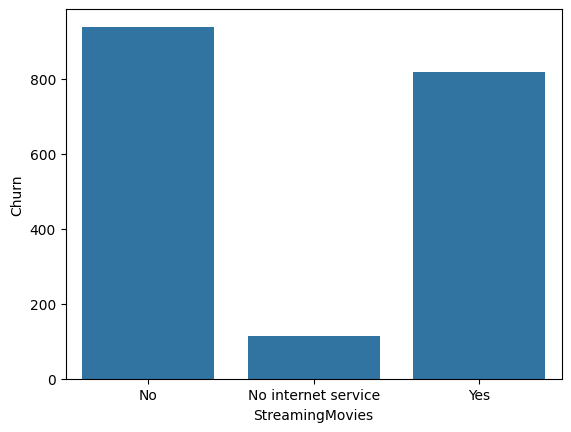

In [177]:
sns.barplot(data = telecom_StreamingMovies_df,x = 'StreamingMovies',y='Churn')

**Conclusion:** The customers who don't have StreamingMovies are churing sighlty more when compared with the people who have StreamingMovies.

Contract and churn Count.

In [178]:
telecom_Contract_df = telecom_pandas_df.groupby('Contract').Churn.sum().reset_index()

In [179]:
telecom_Contract_df

,Contract,Churn
0,Month-to-month,1655
1,One year,166
2,Two year,48


<Axes: xlabel='Contract', ylabel='Churn'>

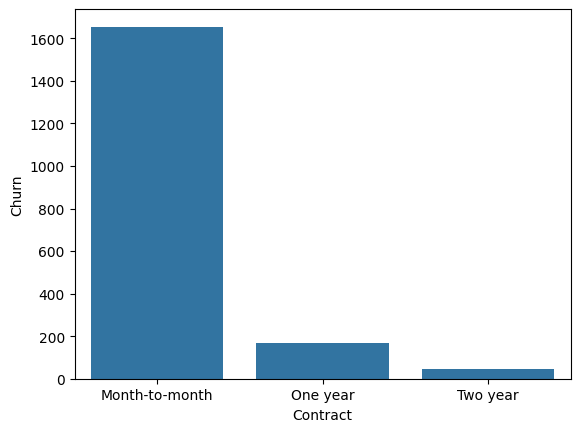

In [180]:
sns.barplot(data = telecom_Contract_df,x = 'Contract',y='Churn')

**Conclusion:** The customers who have Month-to-month contract are churing more.

PaperlessBilling and churn Count.

In [184]:
telecom_PaperlessBilling_df = telecom_pandas_df.groupby('PaperlessBilling').Churn.sum().reset_index()

In [185]:
telecom_PaperlessBilling_df

,PaperlessBilling,Churn
0,No,469
1,Yes,1400


<Axes: xlabel='PaperlessBilling', ylabel='Churn'>

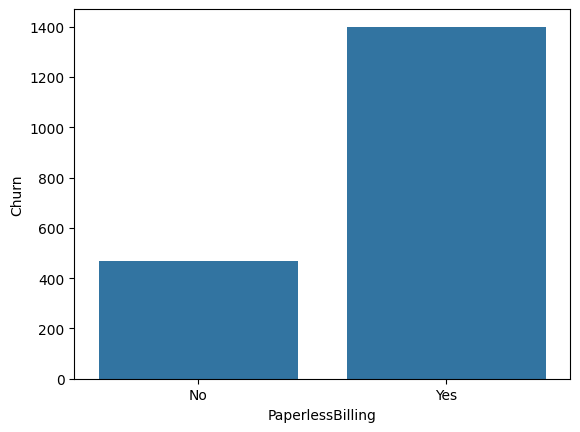

In [186]:
sns.barplot(data = telecom_PaperlessBilling_df,x = 'PaperlessBilling',y='Churn')

Conclusion: The customers who have PaperlessBilling are churing more.

PaymentMethod and churn Count.

In [187]:
telecom_PaymentMethod_df = telecom_pandas_df.groupby('PaymentMethod').Churn.sum().reset_index()

In [188]:
telecom_PaymentMethod_df

,PaymentMethod,Churn
0,Bank transfer (automatic),258
1,Credit card (automatic),232
2,Electronic check,1071
3,Mailed check,308


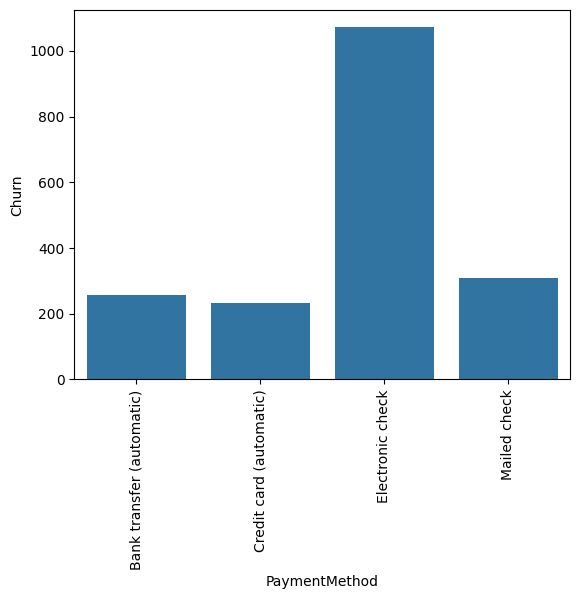

In [192]:
import matplotlib.pyplot as plt
sns.barplot(data = telecom_PaymentMethod_df,x = 'PaymentMethod',y='Churn')
plt.xticks(rotation = 90)
plt.show()

**Conclusion:** The customers who's PaymentMethod is Electronic Check are churing more.

MonthlyCharges and churn Count.

In [193]:
telecom_MonthlyCharges_df = telecom_pandas_df.groupby('MonthlyCharges').Churn.sum().reset_index()

In [194]:
telecom_MonthlyCharges_df

,MonthlyCharges,Churn
0,18,0
1,19,19
2,20,68
3,21,16
4,23,2
...,...,...
96,115,1
97,116,3
98,117,1
99,118,2


<Axes: xlabel='MonthlyCharges', ylabel='Churn'>

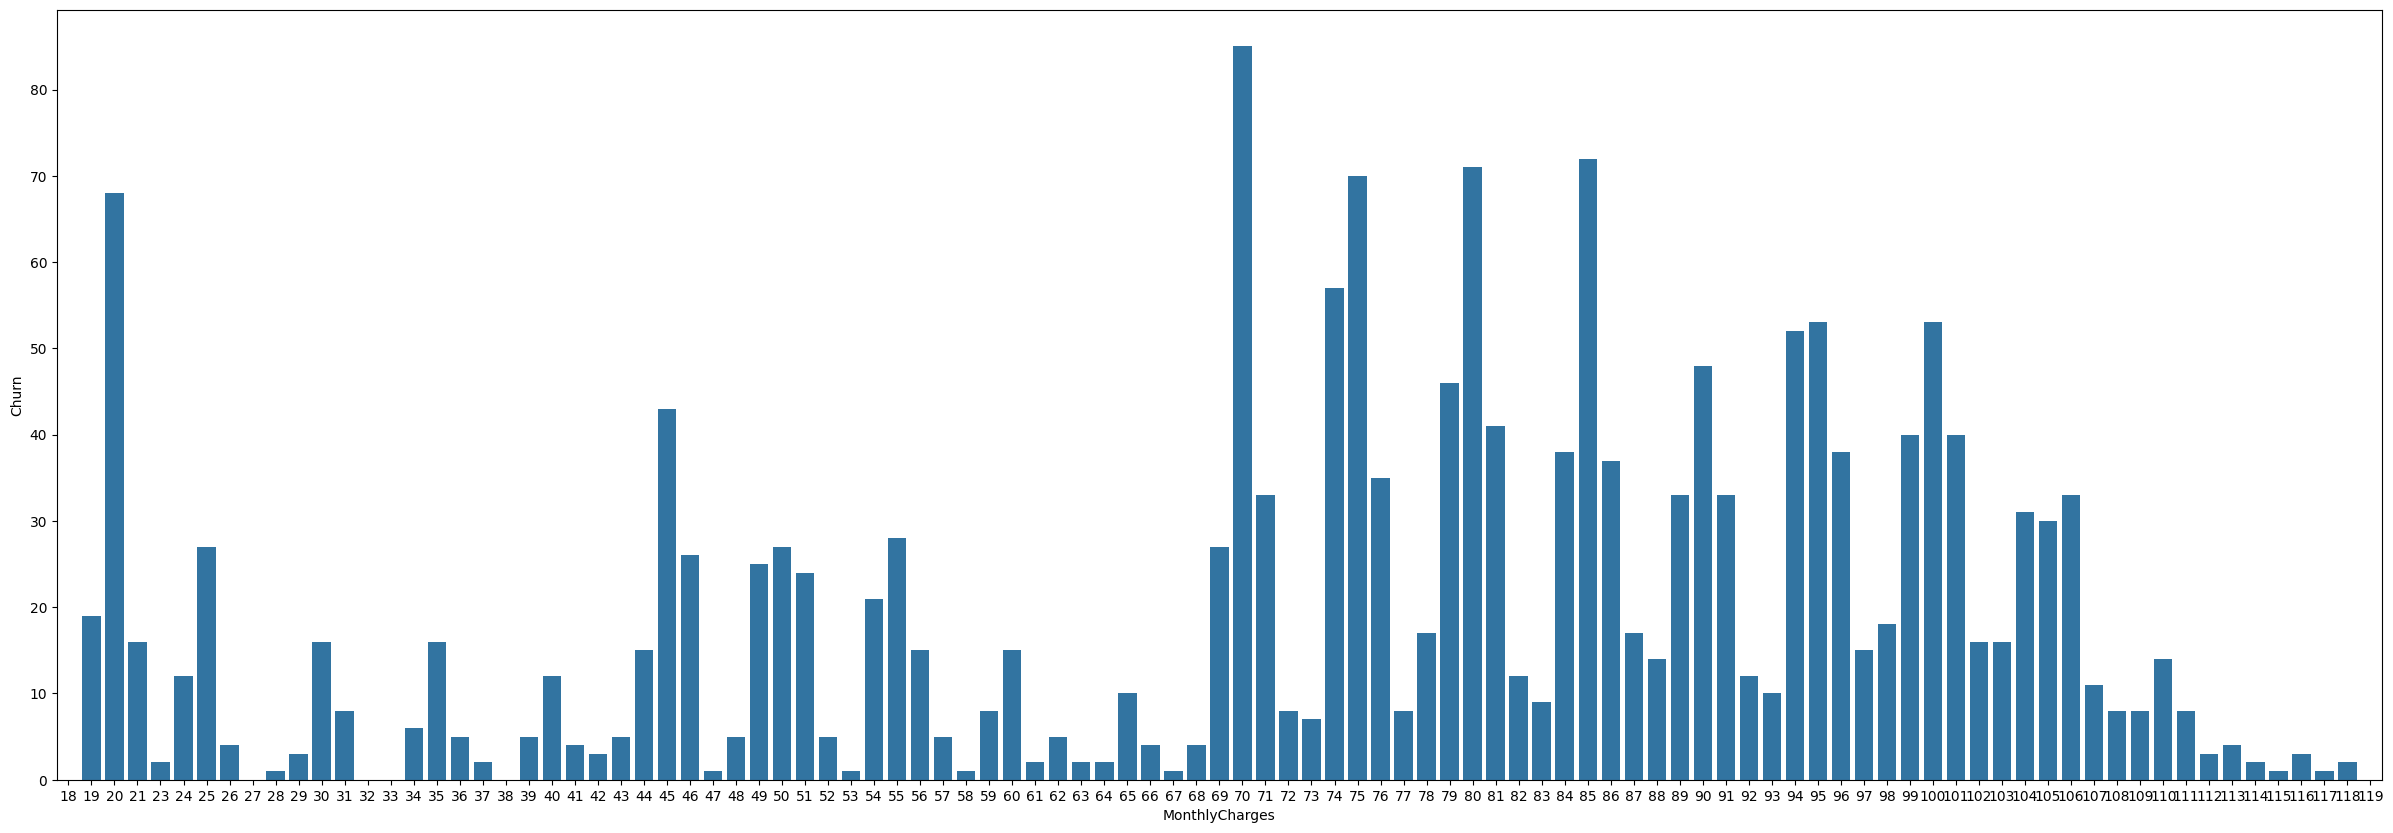

In [201]:
plt.figure(figsize=(30, 10))
sns.barplot(data = telecom_MonthlyCharges_df,x = 'MonthlyCharges',y='Churn')

We are unable to come to a conclusion for this so we will find out correlation between Monthly chargers and churn columns.

In [207]:
correlation_monthlycharges = telecom_pandas_df[['MonthlyCharges','Churn']].corr().iloc[0,1]
print('Correlation between Monthly charges and Churn are : ',correlation_monthlycharges)

Correlation between Monthly charges and Churn are :  0.19323546395915508


TotalCharges and churn Count.

In [209]:
telecom_TotalCharges_df = telecom_pandas_df.groupby('TotalCharges').Churn.sum().reset_index()

In [210]:
telecom_TotalCharges_df

,TotalCharges,Churn
0,19,9
1,20,37
2,21,11
3,23,1
4,24,3
...,...,...
3828,8565,0
3829,8594,0
3830,8670,0
3831,8672,0


As we are getting to many rows, so we will find out correlation between Total charges and Churn.

In [208]:
correlation_totalcharges = telecom_pandas_df[['TotalCharges','Churn']].corr().iloc[0,1]
print('Correlation between Total charges and Churn are : ',correlation_totalcharges)

Correlation between Total charges and Churn are :  -0.19834562349622983


**StringIndexing.**

In [272]:
telecom_df_copy.show(truncate = False)

+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines   |InternetService|OnlineSecurity     |OnlineBackup       |DeviceProtection   |TechSupport        |StreamingTV        |StreamingMovies    |Contract      |PaperlessBilling|PaymentMethod            |MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-------------------------+--------------+------------+-----+
|7590-VHVEG|Female|0            |Yes    |No   

Now let us frop the columns which do not have much impact while predicting.

In [273]:
telecom_df_copy = telecom_df_copy.drop('customerId','gender','MultipleLines','StreamingTV','PaymentMethod','StreamingMovies','Monthlycharges','TotalCharges')

In [274]:
telecom_df_copy.show()

+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|      Contract|PaperlessBilling|Churn|
+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----+
|            0|    Yes|        No|     1|          No|            DSL|                 No|                Yes|                 No|                 No|Month-to-month|             Yes|   No|
|            0|     No|        No|    34|         Yes|            DSL|                Yes|                 No|                Yes|                 No|      One year|              No|   No|
|            0|     No|        No|     2|         Yes| 

In [275]:
telecom_df_copy.printSchema()

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- Churn: string (nullable = true)



In [276]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
Partner_indexer = StringIndexer(inputCol="Partner", outputCol="Partner_encoded")
Partner_model = Partner_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = Partner_model.transform(telecom_df_copy)

In [277]:
telecom_df_copy.show()

+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----+---------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|      Contract|PaperlessBilling|Churn|Partner_encoded|
+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----+---------------+
|            0|    Yes|        No|     1|          No|            DSL|                 No|                Yes|                 No|                 No|Month-to-month|             Yes|   No|            1.0|
|            0|     No|        No|    34|         Yes|            DSL|                Yes|                 No|                Yes|                 No|      One year|              N

In [278]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
Dependents_indexer = StringIndexer(inputCol="Dependents", outputCol="Dependents_encoded")
Dependents_model = Dependents_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = Dependents_model.transform(telecom_df_copy)

In [279]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
PhoneService_indexer = StringIndexer(inputCol="PhoneService", outputCol="PhoneService_encoded")
PhoneService_model = PhoneService_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = PhoneService_model.transform(telecom_df_copy)

In [280]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
InternetService_indexer = StringIndexer(inputCol="InternetService", outputCol="InternetService_encoded")
InternetService_model = InternetService_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = InternetService_model.transform(telecom_df_copy)

In [281]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
OnlineSecurity_indexer = StringIndexer(inputCol="OnlineSecurity", outputCol="OnlineSecurity_encoded")
OnlineSecurity_model = OnlineSecurity_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = OnlineSecurity_model.transform(telecom_df_copy)

In [282]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
OnlineBackup_indexer = StringIndexer(inputCol="OnlineBackup", outputCol="OnlineBackup_encoded")
OnlineBackup_model = OnlineBackup_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = OnlineBackup_model.transform(telecom_df_copy)

In [283]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
DeviceProtection_indexer = StringIndexer(inputCol="DeviceProtection", outputCol="DeviceProtection_encoded")
DeviceProtection_model = DeviceProtection_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = DeviceProtection_model.transform(telecom_df_copy)

In [284]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
TechSupport_indexer = StringIndexer(inputCol="TechSupport", outputCol="TechSupport_encoded")
TechSupport_model = TechSupport_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = TechSupport_model.transform(telecom_df_copy)

In [285]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
Contract_indexer = StringIndexer(inputCol="Contract", outputCol="Contract_encoded")
Contract_model = Contract_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = Contract_model.transform(telecom_df_copy)

In [286]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
PaperlessBilling_indexer = StringIndexer(inputCol="PaperlessBilling", outputCol="PaperlessBilling_encoded")
PaperlessBilling_model = PaperlessBilling_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = PaperlessBilling_model.transform(telecom_df_copy)

In [287]:
from pyspark.ml.feature import StringIndexer

# Initialize the StringIndexer
Churn_indexer = StringIndexer(inputCol="Churn", outputCol="Churn_encoded")
Churn_model = Churn_indexer.fit(telecom_df_copy)

# Fit the indexer to the DataFrame and transform it
telecom_df_copy = Churn_model.transform(telecom_df_copy)

In [288]:
telecom_df_copy.show()

+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+-----+---------------+------------------+--------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+----------------+------------------------+-------------+
|SeniorCitizen|Partner|Dependents|tenure|PhoneService|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|      Contract|PaperlessBilling|Churn|Partner_encoded|Dependents_encoded|PhoneService_encoded|InternetService_encoded|OnlineSecurity_encoded|OnlineBackup_encoded|DeviceProtection_encoded|TechSupport_encoded|Contract_encoded|PaperlessBilling_encoded|Churn_encoded|
+-------------+-------+----------+------+------------+---------------+-------------------+-------------------+-------------------+-------------------+--------------+-------

In [289]:
telecom_df_copy = telecom_df_copy.drop('Partner','Dependents','PhoneService','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport','Contract','PaperlessBilling','Churn')

In [290]:
telecom_df_copy.printSchema()

root
 |-- SeniorCitizen: integer (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- Partner_encoded: double (nullable = false)
 |-- Dependents_encoded: double (nullable = false)
 |-- PhoneService_encoded: double (nullable = false)
 |-- InternetService_encoded: double (nullable = false)
 |-- OnlineSecurity_encoded: double (nullable = false)
 |-- OnlineBackup_encoded: double (nullable = false)
 |-- DeviceProtection_encoded: double (nullable = false)
 |-- TechSupport_encoded: double (nullable = false)
 |-- Contract_encoded: double (nullable = false)
 |-- PaperlessBilling_encoded: double (nullable = false)
 |-- Churn_encoded: double (nullable = false)



In [291]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols = [
        'SeniorCitizen', 'tenure',
        'Partner_encoded', 'Dependents_encoded', 'PhoneService_encoded',
        'InternetService_encoded', 'OnlineSecurity_encoded',
        'OnlineBackup_encoded', 'DeviceProtection_encoded',
        'TechSupport_encoded', 'Contract_encoded',
        'PaperlessBilling_encoded', 'Churn_encoded'
    ],
    outputCol = 'customer_details'
)

telecom_df_copy = assembler.transform(telecom_df_copy)


In [292]:
telecom_df_copy.show()

+-------------+------+---------------+------------------+--------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+----------------+------------------------+-------------+--------------------+
|SeniorCitizen|tenure|Partner_encoded|Dependents_encoded|PhoneService_encoded|InternetService_encoded|OnlineSecurity_encoded|OnlineBackup_encoded|DeviceProtection_encoded|TechSupport_encoded|Contract_encoded|PaperlessBilling_encoded|Churn_encoded|    customer_details|
+-------------+------+---------------+------------------+--------------------+-----------------------+----------------------+--------------------+------------------------+-------------------+----------------+------------------------+-------------+--------------------+
|            0|     1|            1.0|               0.0|                 1.0|                    1.0|                   0.0|                 1.0|                     0.0|                0.0|  

In [294]:
model_inputs = telecom_df_copy.select('Churn_encoded','customer_details')
model_inputs.show(truncate = False)

+-------------+------------------------------------------------------+
|Churn_encoded|customer_details                                      |
+-------------+------------------------------------------------------+
|0.0          |(13,[1,2,4,5,7],[1.0,1.0,1.0,1.0,1.0])                |
|0.0          |(13,[1,5,6,8,10,11],[34.0,1.0,1.0,1.0,2.0,1.0])       |
|1.0          |(13,[1,5,6,7,12],[2.0,1.0,1.0,1.0,1.0])               |
|0.0          |[0.0,45.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,2.0,1.0,0.0]|
|1.0          |(13,[1,12],[2.0,1.0])                                 |
|1.0          |(13,[1,8,12],[8.0,1.0,1.0])                           |
|0.0          |(13,[1,3,7],[22.0,1.0,1.0])                           |
|0.0          |(13,[1,4,5,6,11],[10.0,1.0,1.0,1.0,1.0])              |
|1.0          |(13,[1,2,8,9,12],[28.0,1.0,1.0,1.0,1.0])              |
|0.0          |(13,[1,3,5,6,7,10,11],[62.0,1.0,1.0,1.0,1.0,2.0,1.0]) |
|0.0          |(13,[1,2,3,5,6],[13.0,1.0,1.0,1.0,1.0])               |
|0.0  

Splitting the data into train_data and test_data

In [295]:
train_data,test_data = model_inputs.randomSplit([0.8,0.2],seed = 42)

In [296]:
train_data.show(truncate = False)

+-------------+---------------------+
|Churn_encoded|customer_details     |
+-------------+---------------------+
|0.0          |(13,[0,1],[1.0,1.0]) |
|0.0          |(13,[0,1],[1.0,1.0]) |
|0.0          |(13,[0,1],[1.0,1.0]) |
|0.0          |(13,[0,1],[1.0,1.0]) |
|0.0          |(13,[0,1],[1.0,2.0]) |
|0.0          |(13,[0,1],[1.0,3.0]) |
|0.0          |(13,[0,1],[1.0,4.0]) |
|0.0          |(13,[0,1],[1.0,5.0]) |
|0.0          |(13,[0,1],[1.0,6.0]) |
|0.0          |(13,[0,1],[1.0,6.0]) |
|0.0          |(13,[0,1],[1.0,8.0]) |
|0.0          |(13,[0,1],[1.0,8.0]) |
|0.0          |(13,[0,1],[1.0,9.0]) |
|0.0          |(13,[0,1],[1.0,9.0]) |
|0.0          |(13,[0,1],[1.0,11.0])|
|0.0          |(13,[0,1],[1.0,12.0])|
|0.0          |(13,[0,1],[1.0,14.0])|
|0.0          |(13,[0,1],[1.0,15.0])|
|0.0          |(13,[0,1],[1.0,16.0])|
|0.0          |(13,[0,1],[1.0,17.0])|
+-------------+---------------------+
only showing top 20 rows



In [297]:
test_data.show(truncate = False)

+-------------+---------------------------------------------------+
|Churn_encoded|customer_details                                   |
+-------------+---------------------------------------------------+
|0.0          |(13,[0,1],[1.0,1.0])                               |
|0.0          |(13,[0,1],[1.0,2.0])                               |
|0.0          |(13,[0,1],[1.0,4.0])                               |
|0.0          |(13,[0,1],[1.0,7.0])                               |
|0.0          |(13,[0,1],[1.0,11.0])                              |
|0.0          |(13,[0,1],[1.0,16.0])                              |
|0.0          |(13,[0,1],[1.0,26.0])                              |
|0.0          |(13,[0,1],[1.0,45.0])                              |
|0.0          |(13,[0,1,2],[1.0,7.0,1.0])                         |
|0.0          |(13,[0,1,2],[1.0,11.0,1.0])                        |
|0.0          |(13,[0,1,2],[1.0,14.0,1.0])                        |
|0.0          |(13,[0,1,2],[1.0,17.0,1.0])      